In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [6]:
# Random seed for reproducibility
np.random.seed(42)

# Generate synthetic time series
def generate_sigmoid_series(t, noise=0.1):
    """Generate a sigmoid time series with noise."""
    return 1 / (1 + np.exp(-t)) + noise * np.random.normal(size=t.shape)

def generate_sine_series(t, noise=0.1):
    """Generate a sine time series with noise."""
    return np.sin(t) + noise * np.random.normal(size=t.shape)

# Time axis
t = np.linspace(-10, 10, 100)  # 100 time points

# Create dataset
n_samples = 500
X = []
y = []
for _ in range(n_samples // 2):
    X.append(generate_sigmoid_series(t))
    y.append(1)  # Label for sigmoid

for _ in range(n_samples // 2):
    X.append(generate_sine_series(t))
    y.append(0)  # Label for sine

X = np.array(X)
y = np.array(y)

# Shuffle the dataset
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")


Dataset shape: (500, 100), Labels shape: (500,)


In [9]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [10]:
# Define parameters
params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "logloss",       # Log loss as evaluation metric
    "eta": 0.3,                     # Learning rate
    "max_depth": 4,                 # Depth of trees
    "subsample": 0.8,               # Subsample ratio
    "colsample_bytree": 0.8         # Feature sampling ratio
}


In [11]:
# Train the XGBoost model
num_rounds = 50
bst = xgb.train(params, dtrain, num_rounds)


In [12]:
# Predict on the test set
y_pred = bst.predict(dtest)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


## Statistics of the data

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [16]:
# Separate data by class
class_0 = X[y == 0]  # Sine class
class_1 = X[y == 1]  # Sigmoid class

# Initialize density lists
density_0 = []
density_1 = []

# Calculate the probability density for each feature
for feature_idx in range(X.shape[1]):  # Iterate over time steps
    feature_values_0 = class_0[:, feature_idx]
    feature_values_1 = class_1[:, feature_idx]
    
    # Compute PDFs using Gaussian Kernel Density Estimation (KDE)
    kde_0 = gaussian_kde(feature_values_0)
    kde_1 = gaussian_kde(feature_values_1)
    
    # Define the range for density estimation
    x_range = np.linspace(np.min(X), np.max(X), 100)
    
    # Evaluate the PDFs and store
    density_0.append(kde_0(x_range))
    density_1.append(kde_1(x_range))

# Average the densities over all features
avg_density_0 = np.mean(density_0, axis=0)
avg_density_1 = np.mean(density_1, axis=0)

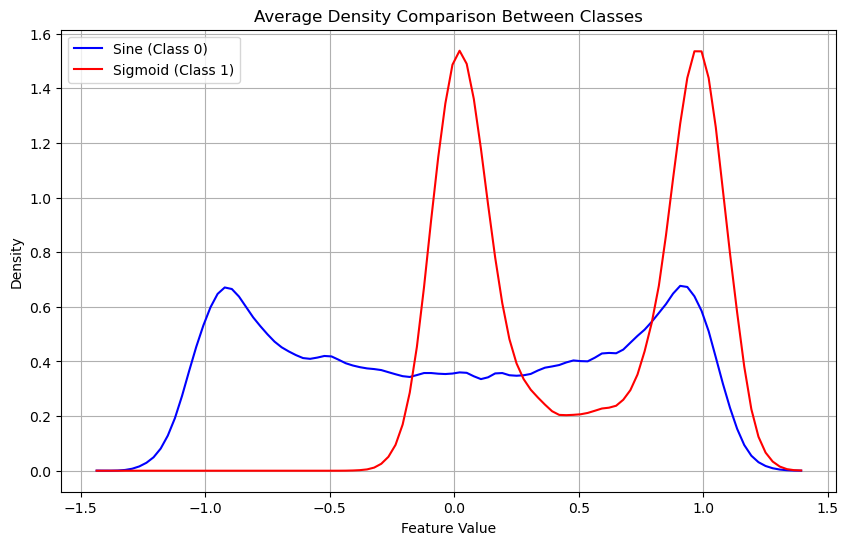

In [17]:
# Plot the averaged PDFs
plt.figure(figsize=(10, 6))
plt.plot(x_range, avg_density_0, label="Sine (Class 0)", color="blue")
plt.plot(x_range, avg_density_1, label="Sigmoid (Class 1)", color="red")
plt.title("Average Density Comparison Between Classes")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()
